In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Question 3

Q2.

In [ ]:
im = Image.open(r"./Truman_receives_menorah_square.jpg").convert('L')
pix = np.array(im)
side_len = pix.shape[0]

In [ ]:
def get_weight_at_point(x,y,epsilon, subsample, curr_coefficiant, p, weight_subsample):
    """ This function calculates the w' of the point x,y in the subsample of the image.
        Meaning, it returns the current updated weight for the point.
        This is done instead of calculating all the values of w' in each iteration and keeping thiem in memory."""
    subsample_df = pd.DataFrame(subsample)
    if float(subsample_df[x][y])-curr_coefficiant < 1E-7 and p<2:
        return np.power(epsilon, -1)
    return np.min([np.power(epsilon, -1),
                  np.power(np.abs(float(subsample_df[x][y])-curr_coefficiant), p-2.0) * weight_subsample[x][y]])

In [ ]:
def get_uni_boundries_from_num_of_reps(num_reps, func_range):
    """ Returns an array with the uniform boundaried, with the lowest boundary at 0."""
    uni_boundries = [0]
    interval_size = func_range / num_reps

    for i in range(num_reps):
        uni_boundries.append(int(uni_boundries[i] + interval_size))
    
    return uni_boundries

In [ ]:
def get_rep_coefficiant(epsilon, subsample, curr_coefficiant, p, weight_subsample):
    """ Returns the represenative value (gamma_i* in our pseudo-code) of the subsample (delta_i in our pseudo-code)."""
    weighted_subsample = np.zeros(shape= subsample.shape)
    total_weight = 0
    for i in range(subsample.shape[0]):
        for j in range(subsample.shape[1]):
            curr_weight = get_weight_at_point(i,j,epsilon, subsample,
                                              curr_coefficiant, p, weight_subsample)
            weighted_subsample[i,j] = subsample[i][j] * curr_weight
            total_weight += curr_weight
    return float(weighted_subsample.sum()) / total_weight

In [ ]:
def get_local_LP_error(pix_submatrix, coefficient, p, weights):
    """ Returns the LP error term for the current coefficient for the sub-image (delta_i in our pseudo-code)."""
    curr_weights = pd.DataFrame(weights)
    curr_matrix = pd.DataFrame(pix_submatrix)
    return np.sum((np.power(np.abs(curr_matrix - coefficient), p) * curr_weights).sum())

In [ ]:
def get_LP_error(pix, rep_coefficients, weight_matrix , p, list_of_xboundries, list_of_yboundries):
    """ Returns the LP error for the whole image for the current recunstruction.
    In each iteration we add the LP error term of a sub-domain and its current representative value."""
    total_error = 0
    total_weight = weight_matrix.sum()
    for i in range(len(rep_coefficients)):
        for j, gamma in enumerate(rep_coefficients[i]):
            lower_x = list_of_xboundries[i]
            upper_x = list_of_xboundries[i+1]
            lower_y = list_of_yboundries[j]
            upper_y = list_of_yboundries[j+1]
            total_error += get_local_LP_error(pix[lower_x:upper_x,lower_y:upper_y],
                                                rep_coefficients[i,j], p,
                                                weight_matrix[lower_x:upper_x,lower_y:upper_y])
    return float(total_error) / total_weight

In [ ]:
# step 1 in the algorithm: pray to god N is a power of two

def LP_rep(pix, sub_sampling_factor, epsilon, p, stopping_diff, weight_func):
    """ Implementation of the LP solver algorithm."""
    epsilon = float(epsilon)
    rep_coefficients = (np.ones(shape=(sub_sampling_factor, sub_sampling_factor)) * 120.0).astype('float64')
    list_of_xboundries = get_uni_boundries_from_num_of_reps(sub_sampling_factor, pix.shape[0])
    list_of_yboundries = get_uni_boundries_from_num_of_reps(sub_sampling_factor, pix.shape[1])
    last_diff = stopping_diff
    weight_matrix = np.asarray([[float(weight_func(x,y)) for x in range(pix.shape[0])] for y in range(pix.shape[0])])
    last_error = get_LP_error(pix, rep_coefficients,
                              weight_matrix , p, list_of_xboundries, list_of_yboundries)
    while(last_diff >= stopping_diff):
        print("new iteration")
        for i in range(sub_sampling_factor):
            for j in range(sub_sampling_factor):
                lower_x = list_of_xboundries[i]
                upper_x = list_of_xboundries[i+1]
                lower_y = list_of_yboundries[j]
                upper_y = list_of_yboundries[j+1]
                rep_coefficients[i][j] = get_rep_coefficiant(epsilon=epsilon,
                                                            subsample=pix[lower_x:upper_x,lower_y:upper_y],
                                                            curr_coefficiant=rep_coefficients[i][j],
                                                            p=p,
                                                            weight_subsample=weight_matrix[lower_x:upper_x,lower_y:upper_y])
        curr_error = get_LP_error(pix, rep_coefficients, weight_matrix, p, list_of_xboundries, list_of_yboundries)
        last_diff = np.abs(last_error - curr_error)
        last_error = curr_error
    return rep_coefficients, last_error

Q3.

In [ ]:
def uni_weight(x,y):
    """ The uniform weight function we give as input to the LP solver algorithm in Q4."""
    return 1

im = Image.open(r"./Truman_receives_menorah_square.jpg").convert('L')
pix = np.array(im)

In [ ]:
def analytical_MAD(rep, pix_shape):
    """ Returns the MAD term for the given image with its representatives in a matrix.
        Size of the representatives matrix is DxD from the algorithm below."""
    MAD = np.kron(rep, np.ones(shape = (pix_shape[0] // rep.shape[0],
                                        pix_shape[1] // rep.shape[1])))
    return np.mean(np.abs(pix - MAD))

In [ ]:
""" Here we copied part of the algorithm from question 2, which does subsampling and reconstruction
    using the MAD sense."""
analytical_MAD_reps = []  # will be list of 2D arrays of represantators of every grid sample region
analytical_MAD_errors = []  # MAD error for every b
for b in range(1,9):
    D_value = np.power(2,b)
    MAD_rep = np.ndarray(shape=(D_value,D_value), dtype=float)
    list_of_xboundries = get_uni_boundries_from_num_of_reps(D_value, pix.shape[0])
    list_of_yboundries = get_uni_boundries_from_num_of_reps(D_value, pix.shape[1])
    for i in range(len(list_of_xboundries) - 1):
        for j in range(len(list_of_yboundries) - 1):
            lower_x = list_of_xboundries[i]
            upper_x = list_of_xboundries[i+1]
            lower_y = list_of_yboundries[j]
            upper_y = list_of_yboundries[j+1]

            # in the MAD sense: our represantator is the sample's median
            sample_median = np.median(pix[lower_x:upper_x,lower_y:upper_y])
            MAD_rep[i][j] = sample_median
    analytical_MAD_errors.append(analytical_MAD(MAD_rep, pix.shape))
    analytical_MAD_reps.append(MAD_rep)

Q4.

In [ ]:
""" Here we computed the LP representations of the image given p = 1 for varying epsilon and N values."""
irls_MAD_reps = []
irls_estimated_errors = []
irls_analytical_errors = []
for b in [2,4,6]:
    for epsilon in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
        D_value = np.power(2,b)
        irls_rep, irls_estimated_error = LP_rep(pix=pix, sub_sampling_factor=D_value, epsilon=epsilon, p=1, 
                                                stopping_diff=0.5, weight_func=uni_weight)
        irls_MAD_reps.append(irls_rep)
        irls_estimated_errors.append(irls_estimated_error)
        irls_analytical_errors.append(analytical_MAD(irls_rep, pix.shape))

In [ ]:
def plotimages(matrix_list):
    """ Plots the recieved matrices side by side. """
    plt.figure(figsize=(20,40))
    for i, b in enumerate([2,4,6]):
        plt.subplot(4,2,b)
        plt.title(f"for a {np.power(2,b)} sub-sampling factor:")
        plt.imshow(matrix_list[i], cmap='gray')

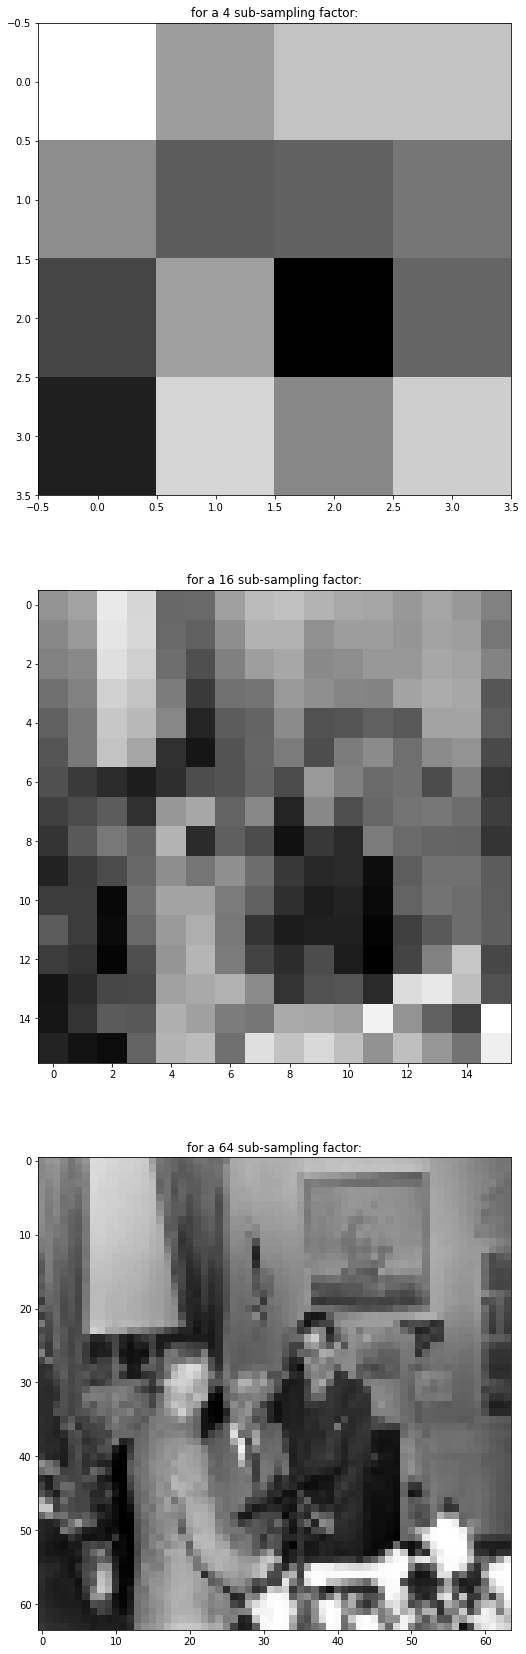

In [ ]:
plotimages(irls_MAD_reps[::6])  # plotting the sampled images from using the LP solver.

In [ ]:
""" Obtaining the L4 representations through our iterative algorithm"""

irls_L4_reps = []
irls_L4_errors = []

for b in range(1,9):
    D_value = np.power(2,b)
    irls_L4_rep, irls_L4_error = LP_rep(pix=pix, sub_sampling_factor=D_value, epsilon=1, p=4, 
                                  stopping_diff=20000, weight_func=uni_weight)
    irls_L4_errors.append(irls_L4_error)
    irls_L4_reps.append(irls_L4_rep)


new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


new iteration
new iteration
new iteration
new iteration
new iteration
new iteration


In [ ]:
""" Obtaining the L1.5 representations through our iterative algorithm"""

irls_L1_and_a_half_reps = []
irls_L1_and_a_half_errors = []

for b in range(1,9):
    D_value = np.power(2,b)
    irls_L1_and_a_half_rep, irls_L1_and_a_half_error = LP_rep(pix=pix, sub_sampling_factor=D_value, epsilon=1, p=1.5, 
                                                              stopping_diff=0.5, weight_func=uni_weight)
    irls_L1_and_a_half_errors.append(irls_L1_and_a_half_error)
    irls_L1_and_a_half_reps.append(irls_L1_and_a_half_rep)

new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration
new iteration


In [ ]:
print("irls_L4_errors: \n", irls_L4_errors)
print("irls_L1_and_a_half_errors: \n", irls_L1_and_a_half_errors)

irls_L4_errors: 
 [33973410.72299675, 22087766.752701778, 19635318.920403257, 14360223.383708533, 7542443.080649059, 3642802.63412069, 1245457.5152016566, 212811.86304469086]
irls_L1_and_a_half_errors: 
 [395.8834481501708, 314.45098825264483, 260.18814966685864, 211.119894192618, 138.38933343704272, 88.77382461939506, 51.54016788187601, 23.98814683263534]


[Text(0, 0.5, 'L4 error'), Text(0.5, 0, 'num of samples')]

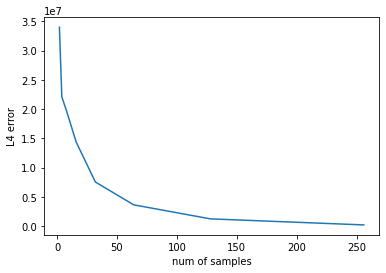

In [ ]:
sns.lineplot(y = irls_L4_errors, x = [np.power(2,b) for b in range(1,9)]).set(xlabel="num of samples",
                                                                              ylabel="L4 error")

[Text(0, 0.5, 'L3/2 error'), Text(0.5, 0, 'num of samples')]

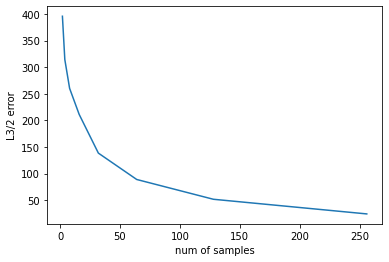

In [ ]:

sns.lineplot(y = irls_L1_and_a_half_errors, x = [np.power(2,b) for b in range(1,9)]).set(xlabel="num of samples",
                                                                                         ylabel="L3/2 error")

In [ ]:
def plot_image_lists(matrix_list1, matrix_list2):
    """ Plots the recieved matrices side by side. """
    plt.figure(figsize=(20,80))
    for b in range(1,8):
        plt.subplot(8,2,2*b-1)
        plt.title(f"for a {np.power(2,b)} sub-sampling factor (L4 sense):")
        plt.imshow(matrix_list1[b-1], cmap='gray')
        plt.subplot(8,2,2*b)
        plt.title(f"for a {np.power(2,b)} sub-sampling factor (L1.5 sense):")
        plt.imshow(matrix_list2[b-1], cmap='gray')

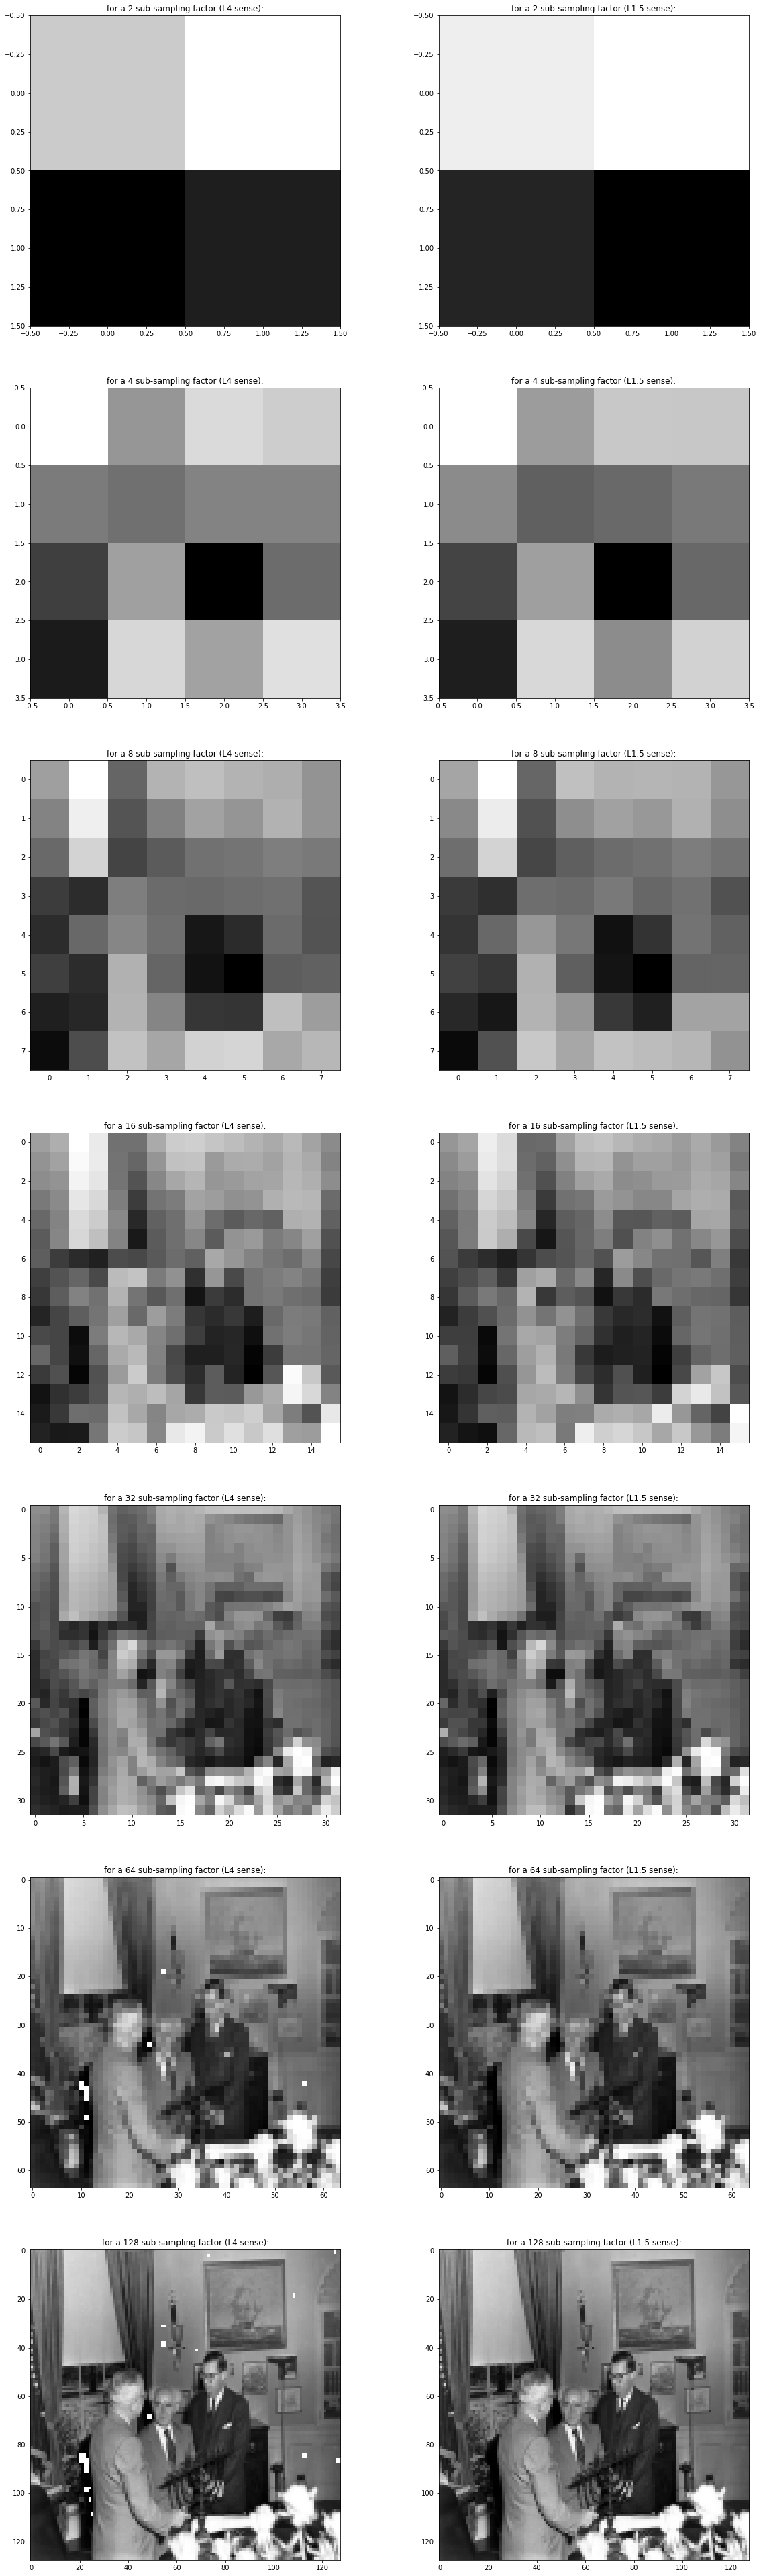

In [ ]:
plot_image_lists(irls_L4_reps, irls_L1_and_a_half_reps)